In [28]:
import torch


print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cu121
Is CUDA available: True


## Dataset Setup and EDA

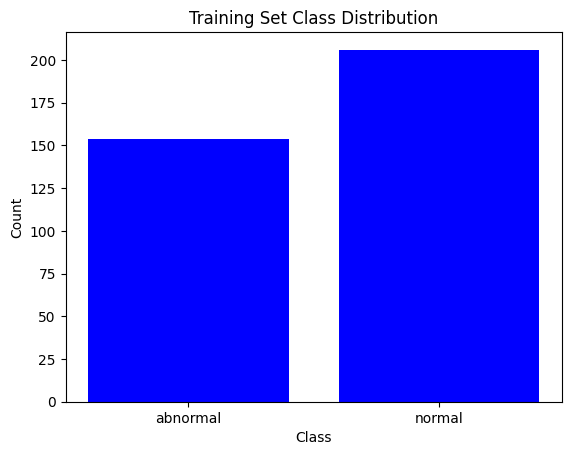

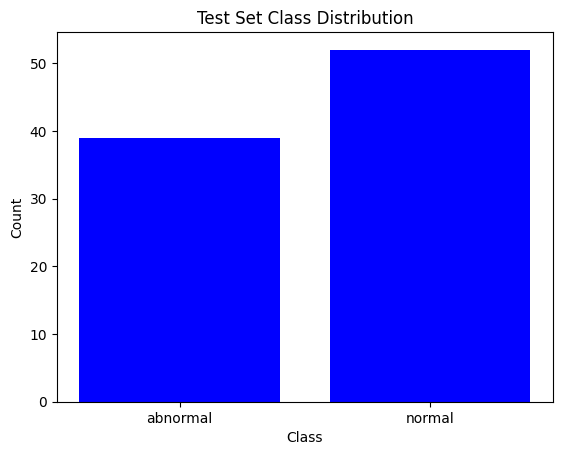

In [29]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def count_images(data_dir):
    """
    Recursively count the images in each class subfolder.
    """
    class_counts = Counter()
    for root, dirs, files in os.walk(data_dir):
        # If there are no further subdirectories, root should be a class folder
        if len(dirs) == 0:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

train_dir = 'C:\\Users\\Moh\\Desktop\\GPTest1\\PanoramicX\\trainX'
 
test_dir  = 'C:\\Users\\Moh\\Desktop\\GPTest1\\PanoramicX\\TestX'

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

# Plot the distribution for train set
plt.bar(train_counts.keys(), train_counts.values(), color='blue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the distribution for test set
plt.bar(test_counts.keys(), test_counts.values(), color='blue')
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


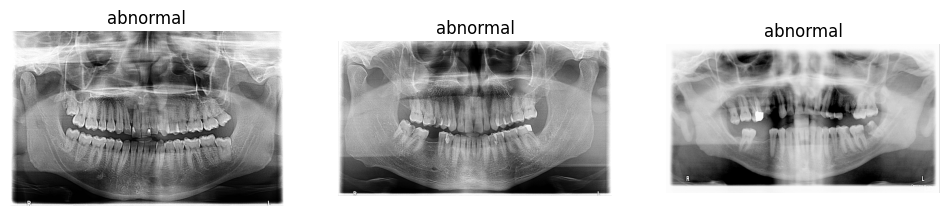

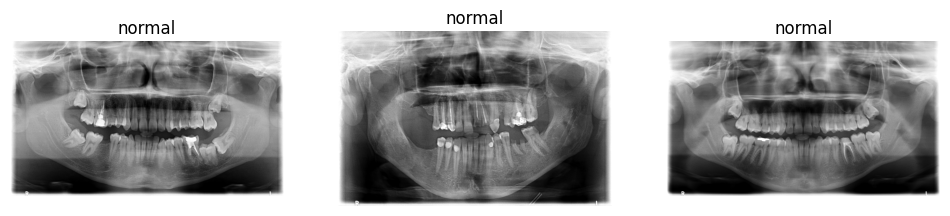

In [30]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_sample_images(data_dir, n_samples=3):
    """
    Display a few random images from each class folder in grayscale.
    """
    classes = [
        cls for cls in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, cls))
    ]
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        try:
            samples = random.sample(os.listdir(cls_path), n_samples)
        except ValueError:
            samples = os.listdir(cls_path)
        plt.figure(figsize=(12, 4))
        for i, sample in enumerate(samples):
            img_path = os.path.join(cls_path, sample)
            img = Image.open(img_path)
            plt.subplot(1, n_samples, i + 1)
            # Display in grayscale by specifying 'cmap=gray'
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
        plt.show()

# Call the function to display sample images from the training set
show_sample_images(train_dir, n_samples=3)


##  Data Preprocessing
 

In [31]:
import torch
import torchvision
from torchvision import transforms

# HEAVY GEOMETRIC AUGMENTATIONS WITHOUT COLOR CHANGES
train_transforms = transforms.Compose([
    # Randomly crop and resize to 224×224, with a wide scale range
    transforms.RandomResizedCrop(300, scale=(0.5, 1.0)),

    # Flip images horizontally and vertically with p=0.5
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    # Rotate the image up to ±45°
    transforms.RandomRotation(degrees=45),

    # Apply random affine transformations (translate up to 30%, shear up to 20°, scale 0.8–1.2)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.3, 0.3),
        scale=(0.8, 1.2),
        shear=20
    ),

    # Distort the perspective substantially
    transforms.RandomPerspective(distortion_scale=0.6, p=0.7),

    # Slight blur to simulate camera imperfections
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),

    # Convert to tensor
    transforms.ToTensor(),

    # Randomly erase a portion of the image with random pixel values
    transforms.RandomErasing(
        p=0.7,
        scale=(0.02, 0.3),
        ratio=(0.3, 3.3),
        value='random'
    ),

    # Standard ImageNet normalization (won't change color distribution, just re-scales)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# For validation/test: minimal transformations
val_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Define The EfficientNet model 

In [32]:
import torch
import torch.nn as nn
import torchvision.models as models

# Number of classes in your dataset (replace with the actual count)
num_classes = 2  # Example: binary classification

# 1. Load ResNet-50 with pretrained weights
model = models.resnet50(pretrained=True)

# 2. (Optional) Freeze all layers except the final layer
# for param in model.parameters():
#     param.requires_grad = False

# 3. Replace the final classification layer
#    The default ResNet-50 has model.fc as its classification layer.
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Now, 'model' is a ResNet-50 instance ready for training on your dataset.


c:\Users\Moh\Desktop\GPTest1\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Moh\Desktop\GPTest1\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train The Model 

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Suppose you've already defined your model, train_loader, val_loader, etc.

# 1. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Move the model to that device
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            # Move data and labels to device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_correct += predicted.eq(labels).sum().item()
            train_total += labels.size(0)
        
        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                # Move validation images/labels to device
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {100.*train_correct/train_total:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {100.*val_correct/val_total:.2f}%")

# 3. Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)


Epoch 1/15
Train Loss: 0.6972, Train Accuracy: 54.51%
Val Loss: 0.7216, Val Accuracy: 54.17%
Epoch 2/15
Train Loss: 0.6483, Train Accuracy: 66.67%
Val Loss: 0.7248, Val Accuracy: 48.61%
Epoch 3/15
Train Loss: 0.6072, Train Accuracy: 65.97%
Val Loss: 0.6610, Val Accuracy: 61.11%
Epoch 4/15
Train Loss: 0.6046, Train Accuracy: 65.97%
Val Loss: 0.7400, Val Accuracy: 56.94%
Epoch 5/15
Train Loss: 0.5528, Train Accuracy: 70.83%
Val Loss: 0.6780, Val Accuracy: 56.94%
Epoch 6/15
Train Loss: 0.5073, Train Accuracy: 74.31%
Val Loss: 0.6086, Val Accuracy: 65.28%
Epoch 7/15
Train Loss: 0.5393, Train Accuracy: 74.31%
Val Loss: 0.6194, Val Accuracy: 63.89%
Epoch 8/15
Train Loss: 0.4581, Train Accuracy: 77.78%
Val Loss: 0.7001, Val Accuracy: 63.89%
Epoch 9/15
Train Loss: 0.4320, Train Accuracy: 79.51%
Val Loss: 0.5827, Val Accuracy: 62.50%
Epoch 10/15
Train Loss: 0.4360, Train Accuracy: 79.17%
Val Loss: 0.8323, Val Accuracy: 51.39%
Epoch 11/15
Train Loss: 0.3582, Train Accuracy: 84.72%
Val Loss: 1.65

## Evaluate the Model 

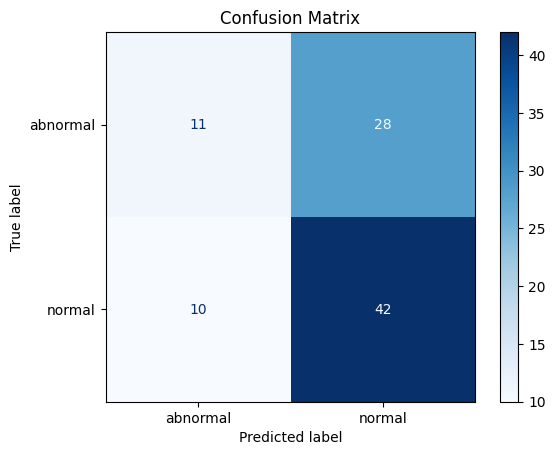

Performance Metrics:
Accuracy: 0.5824
Precision: 0.5673
Recall: 0.5824
F1 Score: 0.5506


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Print metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate
class_names = train_dataset.dataset.classes  # or val_dataset.dataset.classes
evaluate_model(model, test_loader, class_names)
